## Identify hand-drawn digits prototype

### Imports

In [2]:
import torch
import torchvision.transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

### Defining datasets/dataloaders and hyperparameters

In [3]:
INPUT_SIZE: int = 28 * 28
OUTPUT_CLS: int = 10
TRAIN_BATCH_SZ: int = 64
TEST_BATCH_SZ: int = 1000
TRAIN_EPOCH: int = 10
LEARNING_RATE: float = 0.01
MOMENTUM: float = 0.5
LOG_INTERVAL: int = 10

RANDOM_SEED: int = 0x10f2c
torch.manual_seed(RANDOM_SEED)

training_set: datasets.MNIST = datasets.MNIST(
    root= "./data",
    train= True,
    download= True,
    transform= ToTensor()
)

test_set: datasets.MNIST = datasets.MNIST(
    root = "./data",
    train= False,
    download= True,
    transform= ToTensor()
)

train_dl: DataLoader = DataLoader(training_set, batch_size= TRAIN_BATCH_SZ, shuffle= True)
test_dl: DataLoader = DataLoader(test_set, batch_size= TEST_BATCH_SZ, shuffle= False)

device: str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Data Demo

torch.Size([64, 1, 28, 28])


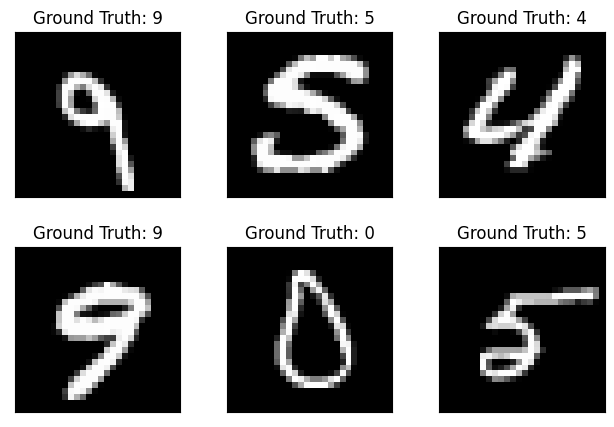

In [4]:
demo = enumerate(train_dl)
demo_idx, (demo_data, demo_target) = next(demo)
print(demo_data.shape)

fig: plt.figure = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(demo_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {demo_target[i]}")
    plt.xticks([])
    plt.yticks([])


### Model Definition

In [5]:
class DigitNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(INPUT_SIZE, 100)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(100, 10)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

model = DigitNetwork().to(device)
print(model)

DigitNetwork(
  (l1): Linear(in_features=784, out_features=100, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=100, out_features=10, bias=True)
)


### Training

In [7]:
criterion: nn.CrossEntropyLoss = nn.CrossEntropyLoss()
optimizer: torch.optim.Adam = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

n_steps = len(train_dl)

for epoch in range(TRAIN_EPOCH):
    for i, (img, label) in enumerate(train_dl):
        img = img.to(device)
        label = label.to(device)
        img = img.reshape(-1, 28 * 28)

        # forward pass
        output = model(img)
        loss: torch.Tensor = criterion(output, label)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % TRAIN_BATCH_SZ == 0:
            print(f"Epoch {epoch + 1}/{TRAIN_EPOCH}, step {i + 1}/{n_steps}, loss = {loss.item():.4f}")

Epoch 1/10, step 64/938, loss = 0.6282
Epoch 1/10, step 128/938, loss = 0.3488
Epoch 1/10, step 192/938, loss = 0.2656
Epoch 1/10, step 256/938, loss = 0.1944
Epoch 1/10, step 320/938, loss = 0.2348
Epoch 1/10, step 384/938, loss = 0.1136
Epoch 1/10, step 448/938, loss = 0.1189
Epoch 1/10, step 512/938, loss = 0.0921
Epoch 1/10, step 576/938, loss = 0.1899
Epoch 1/10, step 640/938, loss = 0.0306
Epoch 1/10, step 704/938, loss = 0.1317
Epoch 1/10, step 768/938, loss = 0.3676
Epoch 1/10, step 832/938, loss = 0.0737
Epoch 1/10, step 896/938, loss = 0.2165
Epoch 2/10, step 64/938, loss = 0.0568
Epoch 2/10, step 128/938, loss = 0.0589
Epoch 2/10, step 192/938, loss = 0.0332
Epoch 2/10, step 256/938, loss = 0.0421
Epoch 2/10, step 320/938, loss = 0.0472
Epoch 2/10, step 384/938, loss = 0.2496
Epoch 2/10, step 448/938, loss = 0.1551
Epoch 2/10, step 512/938, loss = 0.1133
Epoch 2/10, step 576/938, loss = 0.0854
Epoch 2/10, step 640/938, loss = 0.1296
Epoch 2/10, step 704/938, loss = 0.1081
Ep

### Testing

In [13]:
with torch.no_grad():
    correct = 0
    samples = 0
    for img, labels in test_dl:
        img = img.to(device)
        labels = labels.to(device)
        img = img.reshape(-1, 28 * 28)
        output = model(img)

        _, predictions = torch.max(output, 1)
        samples += labels.shape[0]
        correct += (predictions == labels).sum().item()

    acc = 100 * correct / samples
    print(f"Accuracy: {acc}")

Accuracy: 96.9


### Save model


In [10]:
torch.save(model.state_dict, "./digits.pth")

Predicted: 3
Actual: 3


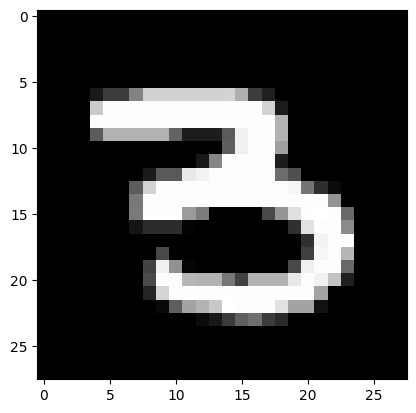

In [83]:
with torch.no_grad():
    idx = int(np.random.rand() * TEST_BATCH_SZ)
    i, (img, label) = next(enumerate(test_dl))
    img = img.to(device)
    plt.imshow(img[idx][0].cpu(), cmap= "gray", interpolation= "none")
    img = img.reshape(-1, 28 * 28)
    label = label.to(device)
    output: torch.Tensor = model(img)

    outlist = [i.item() for i in list(output[idx])]
    print(f"Predicted: {outlist.index(max(outlist))}")
    print(f"Actual: {label[idx]}")
